# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(0.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

[1. 2.]
1.0


In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 2 * x * x - 2.0 * x * y + 3.0 * y * y 

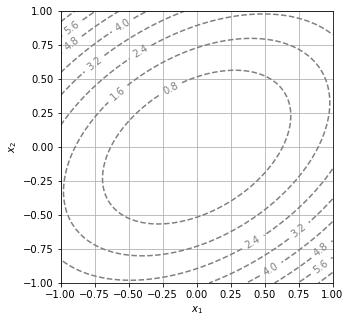

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

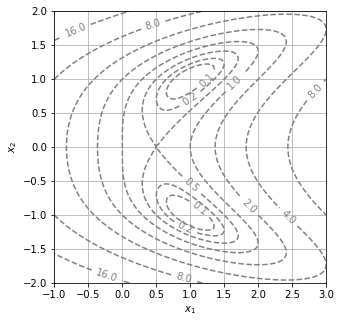

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

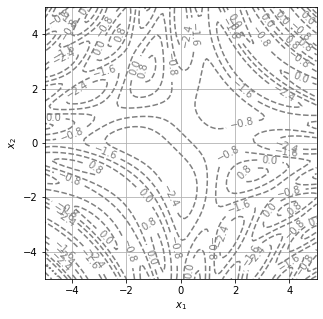

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 0.001
# eps doit être assez petit pour que la précision de la fonction Newton soit intéressante toutefois, eps ne doit 
#pas être trop petit sinon la convergence en N steps n'est pas atteignable.
a = np.ones((2,1))
print(a)

[[1.]
 [1.]]


**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def inverse(F,x,y):
    return np.linalg.inv(J(F)(x,y))
f1_vect=np.vectorize(f1)

def Newton(F, x0, y0, eps=eps, N=N):
    x , y = x0 , y0
    for i in range(N):
        [x , y] = np.array([x0,y0]) - np.dot(inverse(F,x0,y0),F(x0,y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
def fonction(x,y):
    def fonc1(x,y):
        return np.array([f1(x,y)-0.8,x-y]) # remplacer -x par -0.8 pour le test (0.8,0.8)
    return fonc1
#def fonc1(x,y):
      #  return np.array([f1(x,y)-x,x-y])
vect_func=np.vectorize(fonction)
Newton_vect=np.vectorize(Newton)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

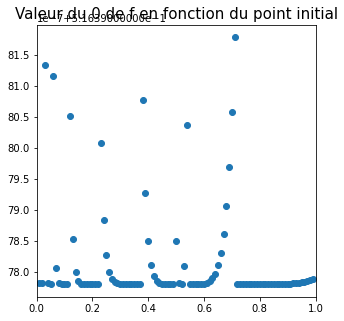

In [20]:
#On applique Newton sur l'intervalle [0,1]

liste = []
for i in range(1,100):
    b,c = Newton(fonction(0.01 * i ,0.01 * i), 0.01 * i, 0.01 * i, eps, N)
    liste.append((0.01 * i,b))
tab = np.array(liste)
#print(tab[:,0])
#print(tab[:,1])
x_min = 0
x_max = 1
y_min = 0
y_max = 1
plt.title('Valeur du 0 de f en fonction du point initial', fontsize=15)

x = np.arange(x_min, x_max, .01)
y = np.arange(y_min, y_max, .01)
plt.xlim(x_min,x_max)
plt.scatter(tab[:,0],tab[:,1])

On remarque que pour certaines valeurs de x, les points s'écartent du 0 habituel 

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

[[ 0.8         0.8851312   0.9584626  ... -0.3259137  -0.42576664
  -0.52570254]
 [ 0.8         0.74753256  0.67954155 ... -0.87086427 -0.87628618
  -0.87270455]]


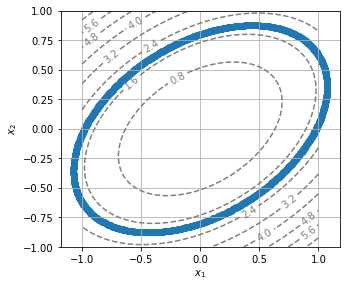

In [21]:
def fonction_level_curve(f,x0,y0,c,delta):
    def fonction1(x,y):
        return np.array([f(x,y)-c,(x-x0)**2+(y-y0)**2-delta**2])
    return fonction1
#on définit la matrice de rotation d'angle -pi/2 pour orienter le gradient vers la droite
matrice_rotation=np.array([(0,1),(-1,0)])

def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    matrice_resultat = np.empty((2,N), dtype= float)
    matrice_resultat[:,0]=np.array([x0,y0]) # construction du point de référence
    c=f(x0,y0)
    for i in range(1,N):
        gradient=grad(f)(x0,y0)
        vecteur=matrice_rotation.dot(gradient)
        norme_vecteur=np.linalg.norm(vecteur)
        nouveau_point= np.array([x0,y0])+(delta/norme_vecteur)*vecteur
        x,y= Newton(fonction_level_curve(f,x0,y0,c,delta),nouveau_point[0],nouveau_point[1],eps,N)
        matrice_resultat[:,i]=np.array([x,y])
        x0,y0=x,y
    return matrice_resultat

print(level_curve(f1, 0.8,0.8,0.1,1000,1e-3))
        
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)


tableau = level_curve(f1, 0.8, 0.8)

plt.scatter(tableau[0], tableau[1])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [22]:
def position_relative(a,b,c):
    ''' 
    renvoie 1 si a2 au dessus de la droite (a0a1)
    renvoie -1 si a2 au dessous de la droite (a0a1)
    renvoie 0 si a2 appartient de la droite (a0a1)
    
    '''
    d = (c[1]-a[1])*(b[0]-a[0]) - (b[1]-a[1])*(c[0]-a[0])
    return 1 if d > 0 else (-1 if d < 0 else 0)

# On suppose que a, b et c sont colinéaires
def interieur_segment(a, b, c):
    '''
    Le programme renvoie True si le point c est dans le segment [a,b], False sinon. 
    '''
    if a[0] < b[0]:
        return a[0] <= c[0] and c[0] <= b[0]
    if b[0] < a[0]:
        return b[0] <= c[0] and c[0] <= a[0]

    if a[1] < b[1]:
        return a[1] <= c[1] and c[1] <= b[1]
    if b[1] < a[1]:
        return b[1] <= c[1] and c[1] <= a[1]

    return a[0] == c[0] and a[1] == c[1]


def intersection(a,b,c,d):
    '''
    Le programme vérifie si les segments [a, b] et [c, d] ont une intersection non vide
    '''
    if (a == b).all():
        return (a == c).all() or (a == d).all()
    if (c == d).all():
        return (c == a).all() or (c == b).all()

    p1 = position_relative(a,b,c)
    p2 = position_relative(a,b,d)

    # Si tous les points sont colinéaires
    if p1 == 0 and p2 == 0:
        return \
            interieur_segment(a, b, c) or interieur_segment(a, b, d) or \
            interieur_segment(c, d, a) or interieur_segment(c, d, b)

    # Si les segments ne se touchent pas et que les points C et D sont du même côté de la droite (AB)
    if p1 and p1 == p2:
        return False

    p1 = position_relative(c,d,a)
    p2 = position_relative(c,d,b)

    # idem
    if p1 and p1 == p2:
        return False

    # Ici, les segments ont une intersection non vide
    return True


def level_curve_corrigee(f, x0, y0, delta=0.1, N=N, eps=eps):
    resultat_matrice = np.empty((2, N), dtype=float)
    c = f(x0, y0)
    
    # Calcul des bornes du 1er segment
    a = np.array([x0, y0])
    resultat_matrice[:,0] = a
    gradient = grad(f)(x0, y0)
    
    # Calcul du point suivant
    vecteur = matrice_rotation.dot(gradient)
    norme_vecteur = np.linalg.norm(vecteur)
    nouveau_point = np.array([x0, y0]) + (delta/norme_vecteur) * vecteur
    x , y = Newton(fonction_level_curve(f, x0, y0, c, delta), nouveau_point[0], nouveau_point[1])
    b = np.array([x, y])
    resultat_matrice[:,1] = b
    x0, y0 = x, y

    # Calcul du point d'après
    gradient = grad(f)(x0, y0)
    vecteur = matrice_rotation.dot(gradient)
    norme_vecteur = np.linalg.norm(vecteur)
    nouveau_point = np.array([x0, y0]) + (delta/norme_vecteur) * vecteur
    x , y = Newton(fonction_level_curve(f, x0, y0, c, delta), nouveau_point[0], nouveau_point[1])
    resultat_matrice[:,2] = np.array([x, y])
    x0, y0 = x, y

    # On calcule tous les points suivants avec la boucle for 
    for i in range(3, N) :
        gradient = grad(f)(x0, y0)
        
        # On se place à un nouveau point dans le sens de grad(f)
        vecteur = matrice_rotation.dot(gradient)
        norme_vecteur = np.linalg.norm(vecteur)
        nouveau_point = np.array([x0, y0]) + (delta/norme_vecteur) * vecteur
        
        # On détermine les nouvelles coordonnées sur le cercle de ce"ntre (x0,y0), de rayon delta
        x , y = Newton(fonction_level_curve(f, x0, y0, c, delta), nouveau_point[0], nouveau_point[1])
        resultat_matrice[:,i] = np.array([x, y])
        
        # On teste ici si on rebouble sur une génération de points précédente ie. on test l'intersection. 
        if intersection(a, b, resultat_matrice[:,i-1], np.array([x, y])) :
            print(f"Auto-intersection après {i} points.")
            return resultat_matrice[:,:i]
        x0, y0 = x, y
        
    return resultat_matrice

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

Auto-intersection après 34 points.


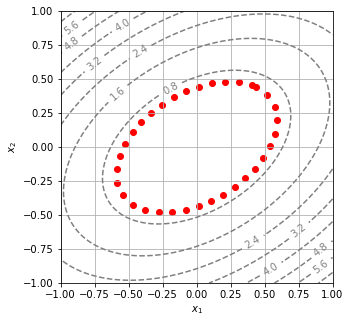

Auto-intersection après 90 points.


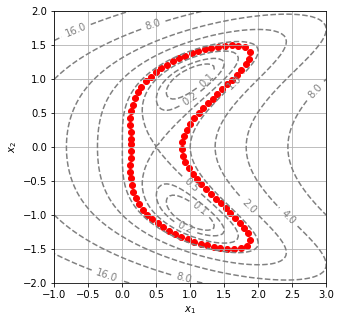

[[ 0.125       0.12100643  0.11828249  0.12025183  0.1301613   0.15054619
   0.18276663  0.22680944  0.28154519  0.34528258  0.41627441  0.49299555
   0.57422453  0.65902353  0.74668536  0.83667937  0.92860692  1.02216747
   1.11713358  1.21333216  1.31062907  1.40891262  1.50806523  1.60788644
   1.70779306  1.8050632   1.87731738  1.86564097  1.81540755  1.75335886
   1.68608839  1.61610362  1.54467306  1.47258579  1.40041781  1.32866277
   1.25781239  1.18842913  1.12122185  1.05717718  0.99777178  0.94533586
   0.90358903  0.87792411  0.873752    0.89218126  0.92883226  0.97793978
   1.03516528  1.09774529  1.1639479   1.23264077  1.30303208  1.37452104
   1.44659571  1.51877156  1.59051381  1.66113475  1.72957892  1.79394084
   1.8497562   1.88163302  1.83647253  1.7427277   1.64317832  1.54321934
   1.44379899  1.34519369  1.2475365   1.15093669  1.05551835  0.96143914
   0.86890543  0.77818948  0.68965197  0.60377247  0.52119011  0.44275485
   0.36958309  0.30309499  0.24497909 

In [24]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

tableau1 = level_curve_corrigee(f1, 0.44, 0.44)
plt.scatter(tableau1[0], tableau1[1], color='red')
plt.show()

#Test sur la fonction f1

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

tableau2 = level_curve_corrigee(f2, 0.125, 0.125)
plt.scatter(tableau2[0], tableau2[1], color='red')
plt.show()
print(tableau2)
#Test sur la fonction f2

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [25]:
def area_squares(f,c,h,l=1):
    compteur = 0
    n = int(l/h)
    for i in range(-n,n):
        for j in range(-n,n):
            if f(i*h,j*h) <= c:
                compteur += 1
    return l*l*compteur/n**2    

In [26]:
#Pour le cercle unité
def f(x,y):
    return x**2 + y**2
area_squares(f,1,0.01)

3.1415

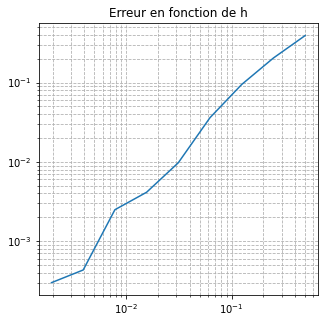

In [27]:
#Étude numérique de l'erreur en fonction de h 

H = [2**i for i in range(-1,-10,-1)]
E = [abs(area_squares(f,1,2**i)-np.pi) for i in range(-1,-10,-1)]

plt.yscale('log')
plt.xscale('log')

plt.grid(True,which="both", linestyle='--')

plt.title('Erreur en fonction de h', fontsize=12)
plt.plot(H,E)
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [28]:
#Au lieu de s'intéresser aux centres des carrés, il s'agit de regarder les coins, si les quatres coins sont dans
#la figure alors on ajoute 1 au compteur, cela permet de fournir une minoration de l'aire
#La méthode précédente donne une majoration! 

def area_squares_min(f,c,h,l=1):
    r_2 = np.sqrt(2)
    compteur = 0
    n = int(l/h)
    for i in range(-n,n):
        for j in range(-n,n):
            x1,y1 = (i*h+r_2*h,j*h+r_2*h)
            x2,y2 = (i*h+r_2*h,j*h-r_2*h)
            x3,y3 = (i*h-r_2*h,j*h+r_2*h)
            x4,y4 = (i*h-r_2*h,j*h-r_2*h)
            if f(x1,y1) <= c and f(x2,y2) <= c and f(x3,y3) <= c and f(x4,y4) <= c:
                compteur += 1
    return l*l*compteur/n**2  

In [29]:
area_squares_min(f,1,0.01)

3.0317

In [30]:
#Approximation de pi à 10-2 près: 
a = area_squares_min(f,1,0.001,l=1)
epsilon = np.pi - a
print(a, " < ", "pi", " < ", a + 2*epsilon)

3.130309  <  pi  <  3.1528763071795862


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

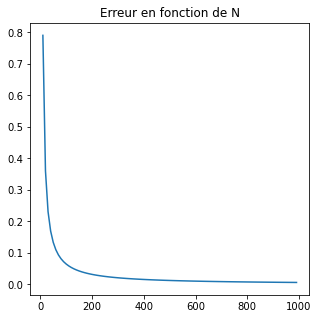

In [31]:
#Commencons par obtenir une description du cercle unité

def triangulation_cercle(N):
    res = []
    for k in range(N,-1,-1):
        res.append((np.cos(2*k*np.pi/N),np.sin(2*k*np.pi/N)))
    return res
                   
points = np.array(triangulation_cercle(10))
points
#plt.scatter(points[:,0],points[:,1])
#Nous aurons besoin de la distance entre deux points

def distance(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

#Nous utiliserons l'aire d'un triangle
def aire_triangle(p1,p2,p3):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    u_x,u_y = (x2-x1,y2-y1)
    v_x,v_y = (x3-x1,y3-y1)
    cos_teta = (u_x*v_x+u_y*v_y)/(np.sqrt(u_x**2+u_y**2)*np.sqrt(v_x**2+v_y**2))
    h = np.sqrt(distance(p1,p2)**2 * (1-cos_teta**2))
    return h*distance(p1,p3)/2
# On a alors : 
def B(N):
    cercle = triangulation_cercle(N)
    aire = 0
    for i in range(N-2):
        aire += aire_triangle((0,0),(cercle[i+1]),(cercle[i+2]))
    return aire

Y = [np.pi-B(i) for i in range(10,1000,10)]
X = [i for i in range(10,1000,10)]
plt.title('Erreur en fonction de N', fontsize=12)
plt.plot(X,Y)
plt.show()

In [27]:
#On observe une branche d'hyperbole, le résultat se rapproche vite de $\pi$ au début puis tend lentement vers 
#le résultat ensuite

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

Commençons par expliquer la méthode de calcul : 

Il est précisé dans l'énoncé que les points doivent êtres donnés dans le sens antihoraire, l'idée du calcul est de regarder le point p, un point p1 de la courbe C et le point p2 qui le suit dans le représentation de C.


On note *p->p1* le vecteur u tel que p + u = p1
    On note (u,v) l'angle d'argument principal **algébrique** (orienté dans le sens trigonométrique) entre u et v.\
Alors : 

---
**si (p->p1,p->p2) > 0 :** alors on ajoute l'opposé de l'aire du triangle (p,p1,p2)

---
**si (p->p1,p->p2) < 0 :** alors on ajoute l'aire du triangle (p,p1,p2)

Pour expliquer le bon fonctionnement de la méthode on peut se placer dans le cas où h est infinitésimal, on va donc pouvoir découper la courbe en 2 parties. 

---
La première, notée P+ sont les points où un déplacement d'un point p_c suivant la courbe correspond à un déplacement angulaire **positif** par rapport à p 

---
La deuxième, notée P-, sont les points où un déplacement d'un point p_c suivant la courbe correspond à un déplacement angulaire **négatif** par rapport à p 

On considère P+ et P- comme des réunions de connexes par arc (Cp+i) et (Cp-j). 
On peut alors calculer l'aire de la manière suivante : 

Aire = somme_j(Aire(EC(Cp-j,p))) - somme_i(Aire(EC(Cp+i,p)))
avec EC(Cp+i) l'enveloppe convexe associée à une partie de courbe est le point p 

Intuitivement, on constate qu'on va ajouter trop d'aire, mais que l'aire extérieure à la figure sera  finalement soustraite au résultat. Cela va donc converger vers l'aire de la figure. 

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

On peut vérifier graphiquement que cela va fonctionner : 
L'aire que le programme va calculer est l'aire grise moins l'aire hachurée. 

<img src='schéma_double_cercle.pdf' width=1000>
* `plt.imshow(im)`
* `plt.show()`


On pourra vérifier la convergence réelle du programme après écriture. 

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [32]:
#Il faut ajouter le fait que lorsqu'on a un angle négatif, l'aire associée doit-être négative.
#On va simplement utiliser le signe du produit vectoriel! 

def produit_vect_positif(u,v):
    xu,yu = u
    xv,yv = v
    return xu*yv - yu*xv > 0




def area_triangle(triangulation,p=(0,0)):
    N = len(triangulation)-1
    xp,yp = p
    aire = 0
    for i in range(N):
        x1,y1 = triangulation[i]
        x2,y2 = triangulation[i+1]
        v1 = (x1-xp,y1-yp)
        v2 = (x2-xp,y2-yp)
        if produit_vect_positif(v1,v2):
            aire -= aire_triangle((p,p),(x1,y1),(x2,y2))
        else:
            aire += aire_triangle((p,p),(x1,y1),(x2,y2))
    return aire

print(area_triangle(triangulation_cercle(10000))[0])

3.141592446566219


On constate immédiatement en faisant tourner les différents programmes que l'aire triangle est bien plus rapide que la méthode des carrés. On le remarque sur les courbes tracés précédemment puisque qu'une hyperbole converge très vite vers sa valeur limite. De manière très théorique: 

---

`area_triangle` est en 0(len(triangulation))

---

`area_squares` est en 0(1/h^2) avec h le pas

---

Le programme `area_squares` va donc prendre un temps arbitrairement grand à calculer des valeurs très précises.


En revanche, la méthode des carrés ne s'appuie pas sur une triangulation. Or, au vu de la complexité d'un programme de génération de point et sa dépendance à la complexité de la fonction f, c'est un avantage certain.

# Cohérence des deux méthodes

### Pour le cercle unité : 

In [33]:
print(area_triangle(triangulation_cercle(100))[0], area_squares_min(f,1,0.001))

3.139525976465647 3.130309


### Pour une fonction quelconque 

L'idée est d'utiliser la fonction génération de points corrigée pour obtenir une triangulation est vérifier la cohérence des deux programmes : 


In [34]:
def comparaison(f,x0,y0,N=N,eps=eps):
    tableau = level_curve_corrigee(f,x0, y0)
    triangulation = [(tableau[0][i],tableau[1][i]) for i in range(len(tableau[0]))]
    c = f(x0,y0)
    print(f)
    print("La méthode des triangles donne : ", area_triangle(triangulation)[0])
    print("La méthode des carrés donne : ", area_squares(f,c,0.01,3))
    return None

comparaison(f1,0.44, 0.44)
comparaison(f2,0.125,0.125)

Auto-intersection après 34 points.
<function f1 at 0x7fef4fde7ca0>
La méthode des triangles donne :  0.8006381558225785
La méthode des carrés donne :  0.8163
Auto-intersection après 90 points.
<function f2 at 0x7fef501889d0>
La méthode des triangles donne :  2.996647506097776
La méthode des carrés donne :  2.9973
